In [1]:
import numpy as np
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('xtick', labelsize=12) 
rc('ytick', labelsize=12)

import emcee

sys.path.append('../../../gwtc3-spin-studies/code/emceeCode/')
import posterior_helper_functions as ph
import postprocessing as pp

sys.path.append('../../../gwtc3-spin-studies/figures/')
import makeCorner as corner

In [2]:
def double_Gaussian(x, mu1, sigma1, mu2, sigma2, f): 
    
    g1 = ph.calculate_Gaussian_1D(x, mu1, sigma1, 0, 1)
    g2 = ph.calculate_Gaussian_1D(x, mu2, sigma2, 0, 1)
    
    return f*g1 + (1-f)*g2

Draw true values from a truncated double gaussian distribution with 30% in a gaussian with $\mu_1=0.1$, $\sigma_1=0.2$ and 70% in a gaussian with $\mu_1=0.8$, $\sigma_1=0.1$.

In [3]:
# True hyperparameters
mu1_true = 0.1
sigma1_true = 0.2
mu2_true = 0.8
sigma2_true = 0.1
f_true = 0.3

# Draw values from this distribution
n_pop = 200
true_values_tmp1 = np.random.normal(loc=mu1_true, scale=sigma1_true, size=1000)
true_values1 = np.random.choice(true_values_tmp1[np.where((true_values_tmp1>=0) & (true_values_tmp1<=1))], size=int(n_pop*f_true))
true_values_tmp2 = np.random.normal(loc=mu2_true, scale=sigma2_true, size=1000)
true_values2 = np.random.choice(true_values_tmp2[np.where((true_values_tmp2>=0) & (true_values_tmp2<=1))], size=int(n_pop*(1-f_true)))
true_values = np.concatenate((true_values1, true_values2))

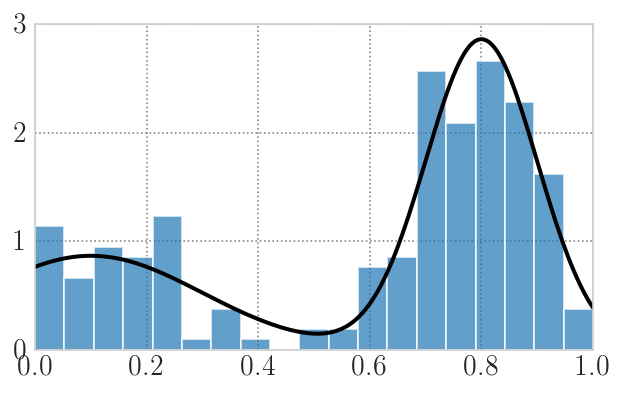

In [4]:
xgrid = np.linspace(0,1,200)

plt.figure(figsize=(5,3))
plt.hist(true_values, density=True, alpha=0.7, bins=np.linspace(0,1,20))
plt.plot(xgrid, double_Gaussian(xgrid, mu1_true, sigma1_true, mu2_true, sigma2_true, f_true), color='k', lw=2)
plt.xlim(0,1)
plt.show()

True values -> measured values

In [5]:
sigma_meas=0.1 # measurement error
measured_values = np.random.normal(loc=true_values, scale=sigma_meas)

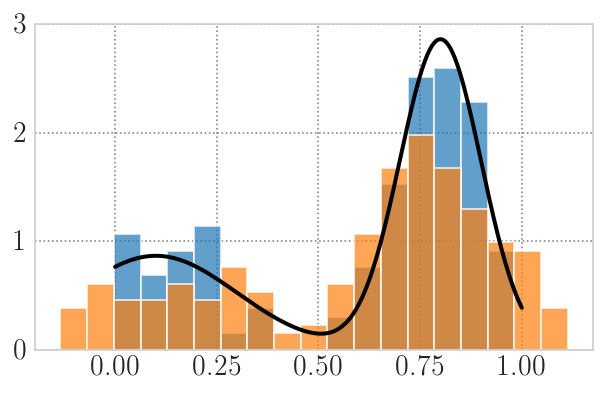

In [6]:
plt.figure(figsize=(5,3))
plt.hist(true_values, density=True, bins=np.linspace(min(measured_values), max(measured_values), 20), alpha=0.7)
plt.hist(measured_values, density=True, bins=np.linspace(min(measured_values), max(measured_values), 20), alpha=0.7)
plt.plot(xgrid, double_Gaussian(xgrid, mu1_true, sigma1_true, mu2_true, sigma2_true, f_true), color='k', lw=2)
#plt.xlim(0,1)
plt.show()

Add measurement error

In [7]:
sampleDict = {}

for i, val in enumerate(measured_values): 
    
    posterior_samps_tmp = np.random.normal(loc=val, scale=sigma_meas, size=20000)
    posterior_samps = np.random.choice(posterior_samps_tmp[np.where((posterior_samps_tmp>=0) & (posterior_samps_tmp<=1))], size=5000)
    
    sampleDict[str(i)] = posterior_samps

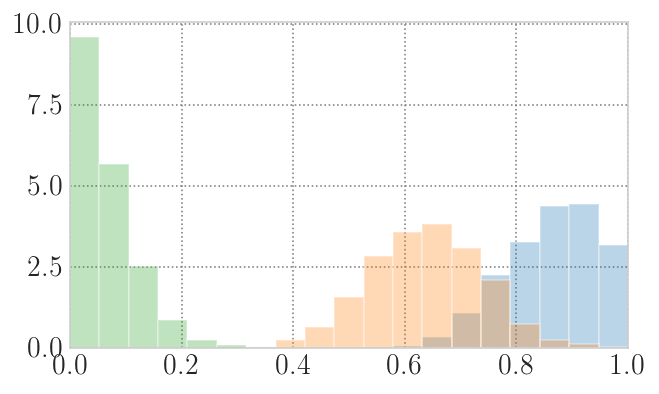

In [9]:
# Plot some example "posteriors" 
plt.figure(figsize=(5,3))
plt.hist(sampleDict[str(np.argmax(true_values))], density=True, alpha=0.3, bins=np.linspace(0,1,20))
plt.hist(sampleDict[str(np.random.choice(len(true_values)))], density=True, alpha=0.3, bins=np.linspace(0,1,20))
plt.hist(sampleDict[str(np.argmin(true_values))], density=True, alpha=0.3, bins=np.linspace(0,1,20))
plt.xlim(0,1)
plt.show()

Write posterior function for sampler

In [10]:
def log_posterior(c,sampleDict): 
    
    # Unpack hyper-parameters
    mu1, sigma1, mu2, sigma2, f = c
    
    # Uniform prior on all parameters
    if mu1 < 0 or mu1 > 1 or mu2 < 0 or mu2 > 1:
        return -np.inf
    elif sigma1 < 0.02 or sigma1 > 1 or sigma2 < 0.03 or sigma2 > 1:
        return -np.inf
    elif f < 0 or f > 1:
        return -np.inf
    
    # Also ensure that mu2 >= mu1 to break degeneracy between the peaks
    elif mu1 > mu2: 
        return -np.inf
    
    else: 
        # Initialize log-posterior
        logP = 0.
        nSamples = len(sampleDict)
        
        # Loop across "events"
        for event in sampleDict:

            # Unpack posterior samples for this event
            samples = sampleDict[event]
            
            # Evaluate model at the locations of samples for this event
            prob = double_Gaussian(samples, mu1, sigma1, mu2, sigma2, f)
            
            # Sum over probabilities to get the marginalized likelihood for this event
            pEvidence = (1.0/nSamples)*np.sum(prob)

            # Add to our running total
            logP += np.log(pEvidence)
                
    return logP

Run sampler

In [11]:
# Dimension of hyperparameter space + number of walks + number of steps
dim = 5
nWalkers = 10 
nSteps = 7000

# Initialize walkers
initial_mu1s = ph.draw_initial_walkers_uniform(nWalkers, (0,1))
initial_sigma1s = ph.draw_initial_walkers_uniform(nWalkers, (0.05,1))
initial_mu2s = ph.draw_initial_walkers_uniform(nWalkers, (0,1))
initial_sigma2s = ph.draw_initial_walkers_uniform(nWalkers, (0.05,1))
intial_fs = ph.draw_initial_walkers_uniform(nWalkers, (0,1))
initial_walkers = np.transpose([initial_mu1s, initial_sigma1s, initial_mu2s, initial_sigma2s, intial_fs])

# Reset sampler if necessary 
try:
    sampler.reset() 
except: 
    print()

# Make sampler
sampler = emcee.EnsembleSampler(
    nWalkers,
    dim,
    log_posterior,
    args=[sampleDict],
    threads=16
)

# Run sampler and print progress as it goes
for i,result in enumerate(sampler.sample(initial_walkers,iterations=nSteps)):
    if i%10==0:
        print(f'On step {i} of {nSteps}', end='\r')

/home/simona.miller/.local/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0


In [12]:
# Get chain
chainRaw = sampler.chain

# Process
chainProcessed = pp.processEmceeChain(chainRaw)

Shape of sample chain:
(10, 7000, 5)
Shape of burned chain:
(10, 5250, 5)
Max correlation length across parameters:
90.61737127300144
Shape of downsampled chain:
(10, 59, 5)
Shape of downsampled chain post-flattening:
(590, 5)


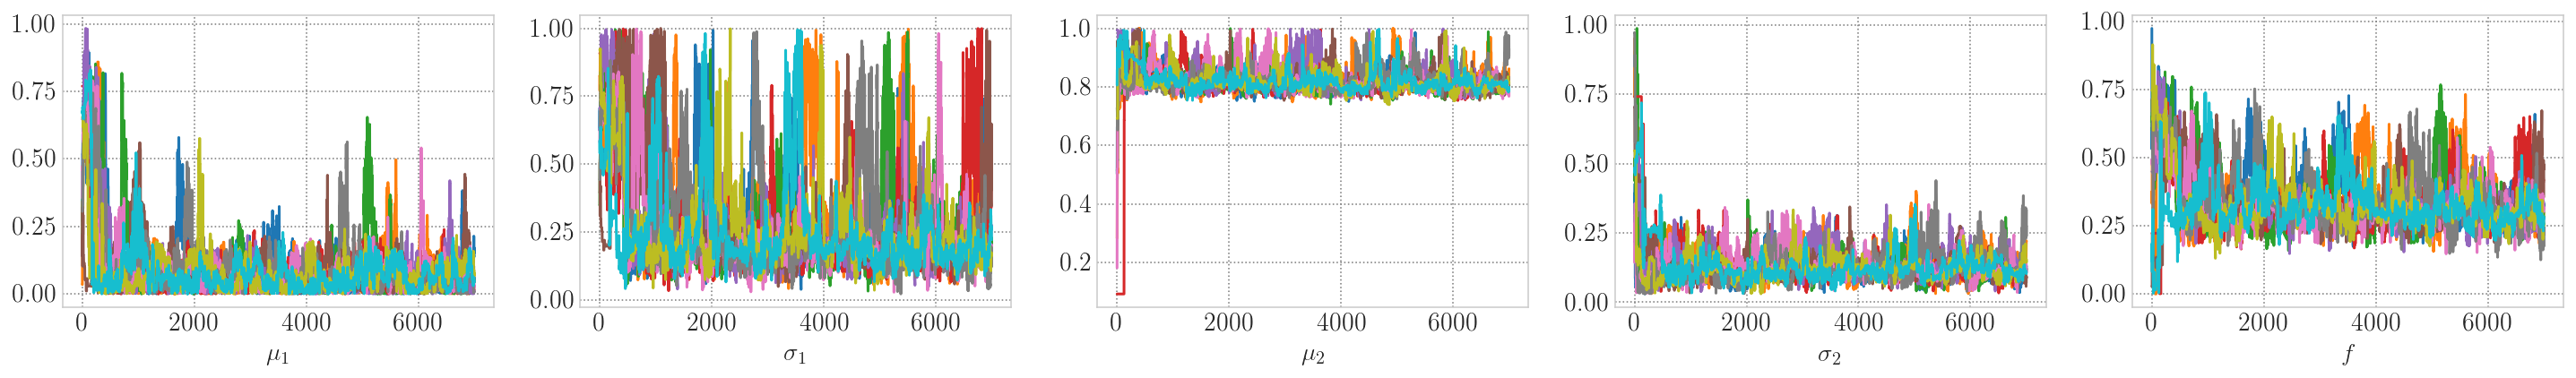

In [13]:
# Plot raw chains

plt.figure(figsize=(25,3))

plt.subplot(151)
plt.plot(np.arange(nSteps), chainRaw[:,:,0].T)
plt.xlabel(r'$\mu_1$', fontsize=14)

plt.subplot(152)
plt.plot(np.arange(nSteps), chainRaw[:,:,1].T)
plt.xlabel(r'$\sigma_1$', fontsize=14)

plt.subplot(153)
plt.plot(np.arange(nSteps), chainRaw[:,:,2].T)
plt.xlabel(r'$\mu_2$', fontsize=14)

plt.subplot(154)
plt.plot(np.arange(nSteps), chainRaw[:,:,3].T)
plt.xlabel(r'$\sigma_2$', fontsize=14)

plt.subplot(155)
plt.plot(np.arange(nSteps), chainRaw[:,:,4].T)
plt.xlabel(r'$f$', fontsize=14)

plt.show()

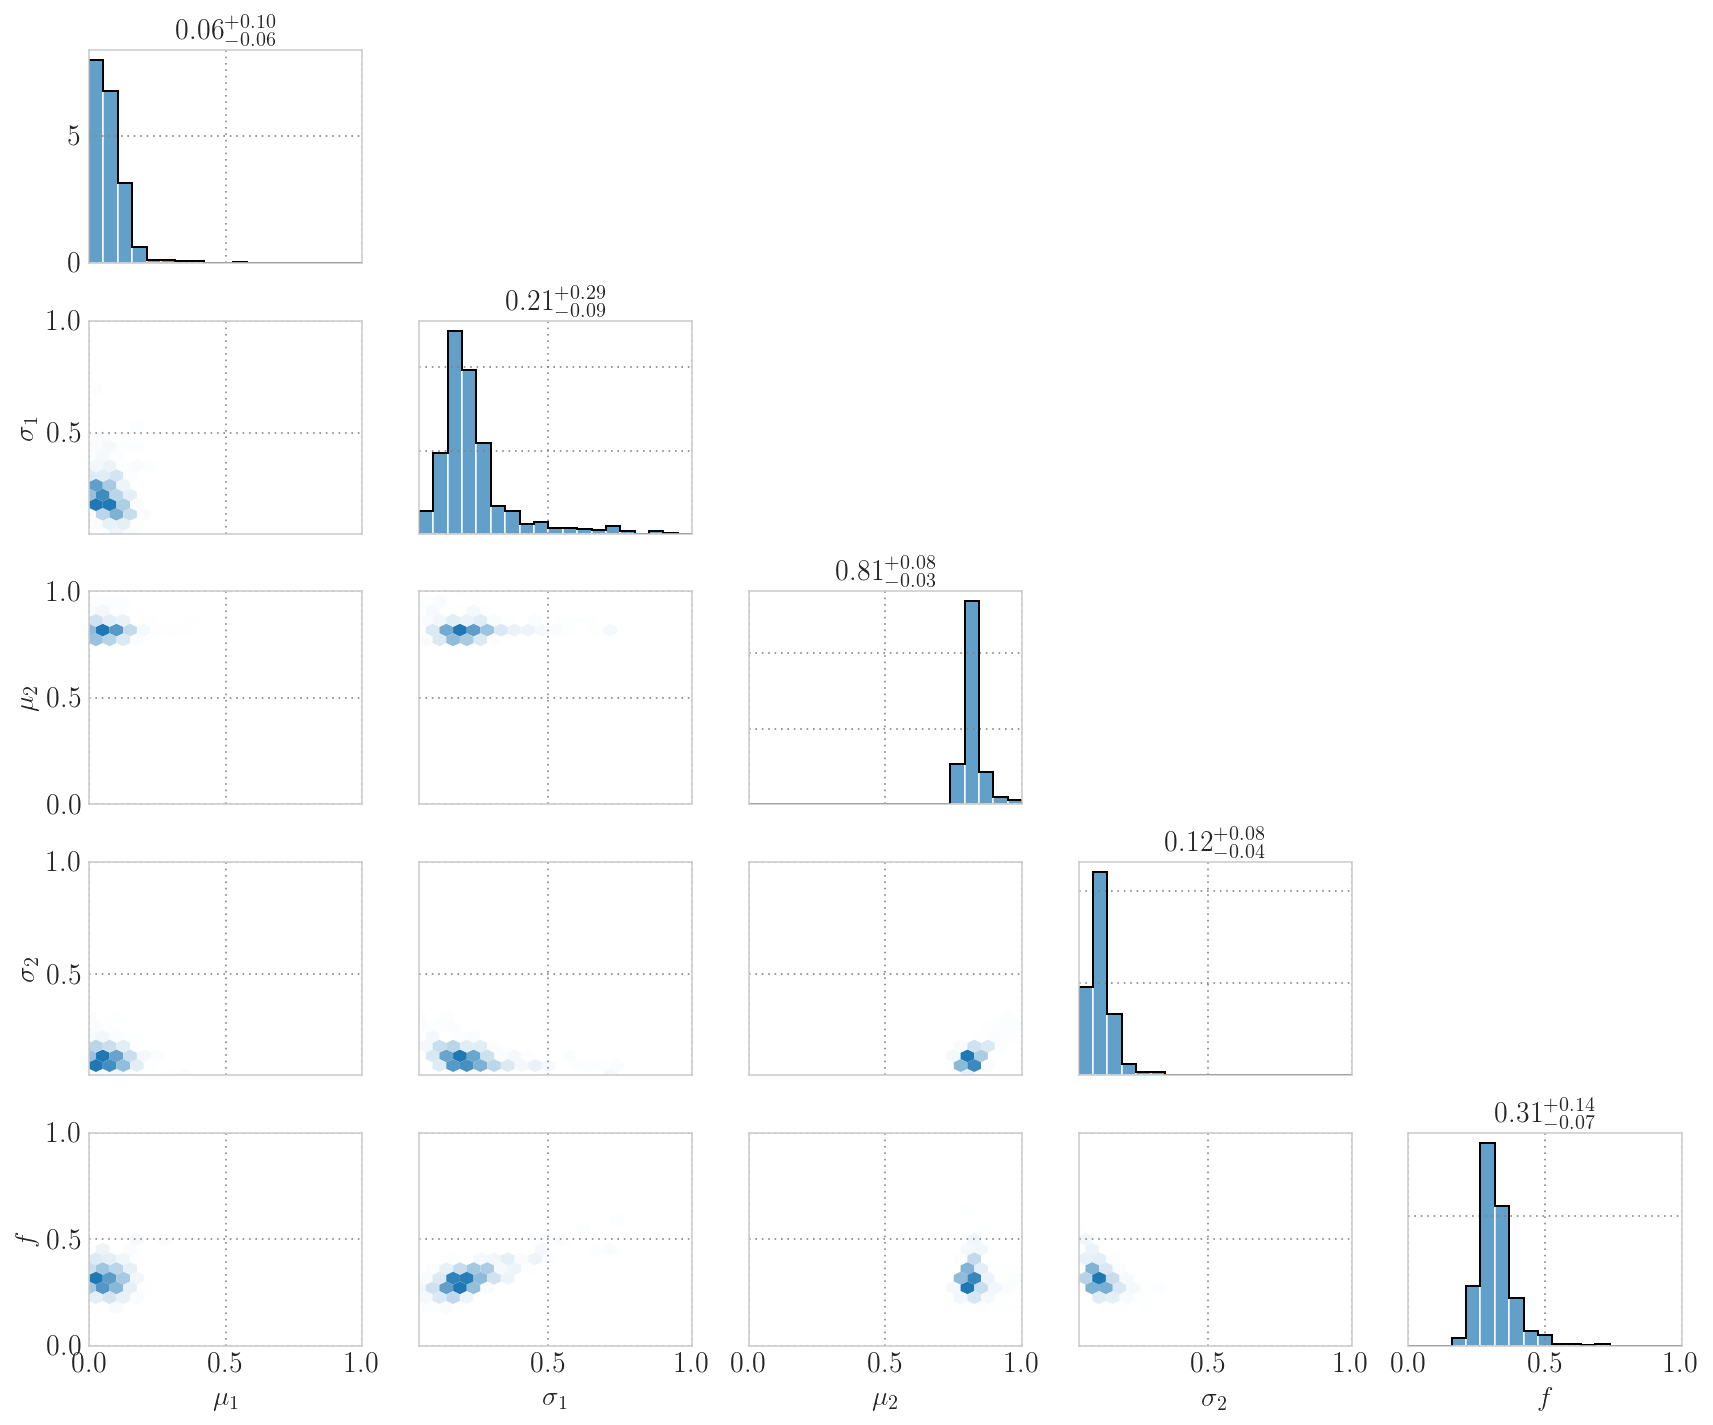

In [14]:
# Cornerplot of processed chains

fig = plt.figure(figsize=(12,10))

toPlot = {
    "mu1":{"data":chainProcessed[:,0], "plot_bounds":(0,1), "label":r"$\mu_1$"},
    "sigma1":{"data":chainProcessed[:,1], "plot_bounds":(0.05,1), "label":r"$\sigma_1$"},
    "mu2":{"data":chainProcessed[:,2], "plot_bounds":(0,1), "label":r"$\mu_2$"},
    "sigma2":{"data":chainProcessed[:,3], "plot_bounds":(0.05,1), "label":r"$\sigma_2$"},
    "f":{"data":chainProcessed[:,4], "plot_bounds":(0,1), "label":r"$f$"},
}

corner.plot_corner(fig,toPlot,'#1f78b4',labelsize=14)
plt.tight_layout()
plt.show()

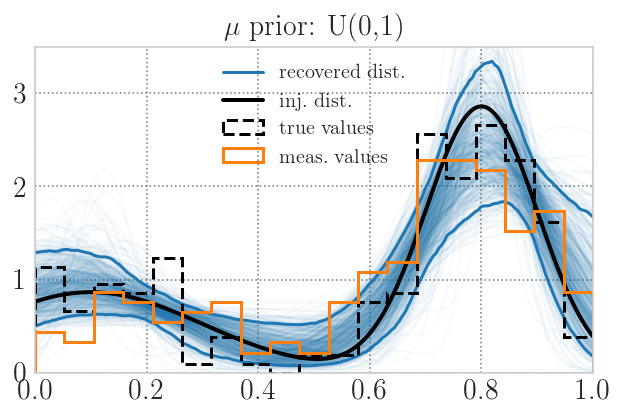

In [15]:
# Trace plot 

plt.figure(figsize=(5,3))

traces = np.zeros((len(xgrid), chainProcessed.shape[0]))
for i,samp in enumerate(chainProcessed): 
    mu1,sigma1,mu2,sigma2,f=samp
    traces[:,i] = double_Gaussian(xgrid, mu1, sigma1, mu2, sigma2, f)
    
plt.plot(xgrid, traces, color='#1f78b4', alpha=0.03, lw=1)
plt.plot(xgrid, np.quantile(traces, 0.05, axis=1), color='#1f78b4', lw=1.5)
plt.plot(xgrid, np.quantile(traces, 0.95, axis=1), color='#1f78b4', lw=1.5, label='recovered dist.')
plt.plot(xgrid, double_Gaussian(xgrid, mu1_true, sigma1_true, mu2_true, sigma2_true, f_true), color='k', lw=2, label=r'inj.~dist.')

plt.hist(true_values, density=True, bins=np.linspace(0,1,20), histtype='step', lw=1.5, color='k', ls='--', label='true values')
plt.hist(measured_values, density=True, bins=np.linspace(0,1,20), histtype='step', lw=1.5, color='C1', label=r'meas.~values')

plt.title(r'$\mu$ prior: U(0,1)', fontsize=14)
plt.legend(fontsize=10)
    
plt.xlim(0,1)
plt.ylim(0,3.5)
plt.show()